In [1]:
import numpy as np
import pylab as plt
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from matplotlib.ticker import FixedLocator
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import matplotlib.gridspec as gridspec
from pprint import pprint
from tqdm import tqdm
import math
import itertools
from IPython.display import clear_output
import pickle
import datetime
from datetime import *
plt.ion()
plt.show()

Implementation for algorithm described in : http://www.naun.org/main/NAUN/computers/20-713.pdf

In [2]:
P = 'HPHPPHHPHPPHPHHPPHPH'
print(len(P))
# TO DO create random generator for input population
P = list(P) # transform input string into array
print('input: ', P)

# this dictionary maps directions to integer values which can become indexes in actions matrix
moves = {'R':0, 'D': 1, 'L': 2, 'U': 3}
pi = 'RUULDLULLDRDRDLDRRU'
pi = list(pi)
pi = list(map(lambda x : moves[x], pi))
print(len(pi))
print('output: ', pi)

20
input:  ['H', 'P', 'H', 'P', 'P', 'H', 'H', 'P', 'H', 'P', 'P', 'H', 'P', 'H', 'H', 'P', 'P', 'H', 'P', 'H']
19
output:  [0, 3, 3, 2, 1, 2, 3, 2, 2, 1, 0, 1, 0, 1, 2, 1, 0, 0, 3]


Utility methods for visualisation of policies:

[(2, 3), (2, 4), (3, 4), (4, 4), (4, 3), (3, 3), (3, 2), (4, 2), (4, 1), (4, 0), (3, 0), (3, 1), (2, 1), (2, 2), (1, 2), (1, 1), (0, 1), (0, 2), (0, 3), (1, 3)] [[ 0. -1.  1. -1.  0.]
 [ 0. -1.  1.  1.  0.]
 [ 0. -1.  1.  1. -1.]
 [-1.  1.  1.  1.  1.]
 [-1.  1. -1. -1. -1.]]


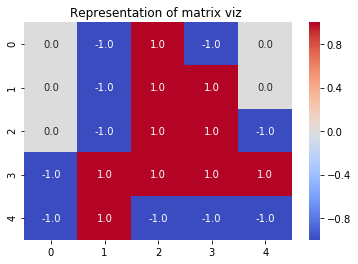

In [3]:
def updateCurrentIndex(x, y, action):
    if action == moves['U']:
        x = x + 1
    elif action == moves['D']:
        x = x - 1
    elif action == moves['R']:
        y = y + 1
    else:
        y = y - 1
    return x, y

def getActionValue(prot_type):
    return 1 if prot_type == 'H' else -1

"""
Visualize the content of a matrix as a heatmap
"""
def plotMatrix(m, label = ''):
    plt.title('Representation of matrix %s '%(label))
    sns.heatmap(m,  cmap='coolwarm', annot=True, fmt=".1f");

"""
Generates a matrix representing the 2D model of the protein based on the sequence of actions pi
"""
def getVisualizationMatrixAndPoints(P, pi):
    l = 2* len(pi)
    viz = np.zeros([l+1, l+1]) # visualization matrix initialized with 0
    points = [] # this will hold the order of points
    cur_x, cur_y = len(pi), len(pi)
    points.append((cur_x, cur_y))
    viz [cur_x, cur_y] = getActionValue(P[0]) # initialize center of the matrix
    for  action, prot_type in zip(pi, P[1:]):   
        cur_x, cur_y = updateCurrentIndex(cur_x, cur_y, action)
        viz [cur_x, cur_y] = getActionValue(prot_type)
        points.append((cur_x, cur_y))
        
    points = list(map(list, zip(*points))) # separate list of tuple points into a list with 2 arrays: x an y coordinates
    # substract from x and y coordinates min values in order to remove 0 based columns and rows
    points = list(zip(list(map(lambda x: x - min(points[0]), points[0] )),
        list(map(lambda x: x - min(points[1]), points[1] ))))
    
    # this removes all columns and rows padded with 0s
    viz = viz[~np.all(viz == 0, axis=1)]
    viz = viz[:, ~np.all(viz == 0, axis=0)]
        
    return viz, points


viz, points =getVisualizationMatrixAndPoints(P, pi)
print(points, viz)

plotMatrix(viz, 'viz')

In [4]:
"""
This method generates an annotated graph representation for the input string of hydrophobic / polar aminacids 
and the policy pi of actions to be taken at each step
"""

def plotSolution(P, pi):
    viz, lines = getVisualizationMatrixAndPoints(P, pi)
    print(viz, lines)
    
    fig = plt.figure(figsize=(7,7))
    # set circleSize and plot
    circleSize = 1000 # in points²
    
    # Split graphic into 2 sections for the 2d map and the input viz
    gs = gridspec.GridSpec(2, 1, width_ratios=[1], height_ratios=[5,1]) 
    
    # Section1 : 2D map
    ax = plt.subplot(gs[0]) # use first grid spec

    y, x = np.where(viz == 1) # hydrophobic AA
    plt.scatter(x, y, s=circleSize, c='orange', alpha=0.4)

    y, x = np.where(viz == -1) # hydrophilic AA
    plt.scatter(x, y, s=circleSize, c='green', alpha=0.4 )
    
    plt.legend(['Hydrophobic amino acids', 'Hydrophilic amino acids '], loc='center left', bbox_to_anchor=(1, 0.5),
               fancybox=True, shadow=True)
#     plt.xlim(0,5)
#     plt.ylim(0,5)

    figSize = (fig.get_figwidth(),fig.get_figheight()) # in inches
    axSize = (plt.xlim()[1]-plt.xlim()[0],plt.ylim()[1]-plt.ylim()[0]) # in 'axis units'
    circleRadius = math.sqrt(circleSize/math.pi) # in points (dots)
    circleRadius /= fig.dpi # in inches
    circleHOffset = circleRadius * (axSize[0]/figSize[0]) # inch * (axis/inch) -> axis
    circleVOffset = circleRadius * (axSize[1]/figSize[1]) # inch * (axis/inch) -> axis

    shrinkHV = [circleHOffset, circleVOffset]
    
    # Write numbers on circles
    for i, point in enumerate(lines):
        if i + 1 == len(lines):
            ax.annotate(i + 1, xy=(point[1], point[0]), va="center", ha="center")
            break
        nextPoint = lines[i+1]
        ax.annotate(i + 1, 
                    xy=(point[1] , point[0]),
                    va="center", ha="center",
                   )
        ax.annotate('', 
                    xytext=(point[1] , point[0] ),
                    xy=(nextPoint[1] , nextPoint[0]),
                    arrowprops=dict(facecolor='black', shrink=shrinkHV[int(nextPoint[0]!=point[0])]),
                       )


    plt.xticks([], [])
    plt.yticks([], [])
    grid_indexes = np.arange(viz.shape[0])
    grid_indexes = grid_indexes + 0.5
    minor_locator = FixedLocator(grid_indexes)
    ax.xaxis.set_minor_locator(minor_locator)


    grid_indexes = np.arange(viz.shape[1])
    grid_indexes = grid_indexes + 0.5
    minor_locator = FixedLocator(grid_indexes)
    ax.yaxis.set_minor_locator(minor_locator)




    plt.grid(which='minor')
    sns.despine()
    plt.title('2D representation of proteins')

    # Section2 : input/ policy annotation
    ax = plt.subplot(gs[1])

    at = AnchoredText("Input: \n %s \n Directions: \n %s" % (P, pi),
                      prop=dict(size=12), frameon=True,
                      loc=1,
                      )
    at.patch.set_boxstyle("round,pad=0.2,rounding_size=0.4")
    ax.add_artist(at)

    plt.axis('off');
#     plt.tight_layout()
    
# plotSolution(P, pi)

[[ 0. -1.  1. -1.  0.]
 [ 0. -1.  1.  1.  0.]
 [ 0. -1.  1.  1. -1.]
 [-1.  1.  1.  1.  1.]
 [-1.  1. -1. -1. -1.]] [(2, 3), (2, 4), (3, 4), (4, 4), (4, 3), (3, 3), (3, 2), (4, 2), (4, 1), (4, 0), (3, 0), (3, 1), (2, 1), (2, 2), (1, 2), (1, 1), (0, 1), (0, 2), (0, 3), (1, 3)]


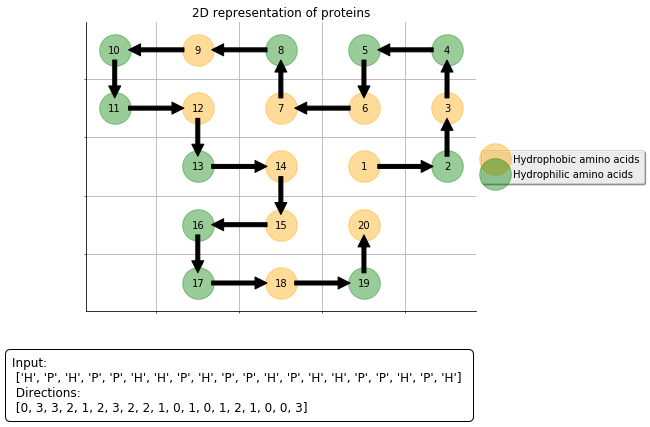

In [5]:
plotSolution(P, pi)

The following method validates a configuration :
<img src ='img/valid_configuration.PNG'> </img>

In [6]:
def validConfiguration(points):
    for i, point in enumerate(points):
        if i+1 == len(points):
            return True
        
        if abs(points[i][0] - points[i + 1][0]) + abs(points[i][1] - points[i + 1][1]) != 1:
#             print('#', end = '')
            return False
        
        if len(points) != len(set(points)):
#             print('>', end = '')
            return False
        
validConfiguration(points)

True

<img src = 'img/energy_function.PNG'></img>

In [7]:
def energyFunction(points, P):
    I = 0
    for i in range(len(points)):
        for j in range(len(points)):
            if abs(i-j) >=2:
                if abs(points[i][0] - points[j][0]) + abs(points[i][1] - points[j][1]) == 1 and P[i] == 'H' and P[j] == 'H':
                    I = I -1
    return I // 2 # we have to divide by 2 because we considered the pairs twice
                    
                
energyFunction(points, P)              

-9

In [8]:
def reward(P, pi, log = False):
    viz, points =getVisualizationMatrixAndPoints(P, pi)

    if validConfiguration(points) == False:
        return 0.01
    
    if len(pi) == (len(P) -1):
        if log:
            print('VALID %s ' % pi)
        return -1 * energyFunction(points, P)
    return 0.1

def qScore(Q):
    if (np.max(Q) > 0):
        return(np.sum(Q/np.max(Q)*100))
    else:
        return (0)
    
reward(P, pi)

9

Static parameters:

In [9]:
N = len(P)-1 # number of iterations to cover the protein
gamma = .8 # discount factor for future rewards
lr= 0.8 # learning rare
MOVE_SIZE = 4 # number of available moves

In [10]:
"""
Parameter pruneTree creates a smaller version of the graph by harcoding the first state to 0
"""
def initializeQ(P, pruneTree = False):
    Q = {}
    directions = ['0', '1', '2', '3']
    states = None
    for el in range(len(P) - 1):
        if states == None:
            states = directions
            Q['start'] = [0] * MOVE_SIZE
            if pruneTree:
                Q['0'] = [0] * MOVE_SIZE
            else:
                for e in directions:
                    Q[str(e)] = [0] * MOVE_SIZE
        else:
            newstates = []
            for i, j in itertools.product(states, directions):
                newstates.append(str(i) + str(j))
                Q[str(i) + str(j)] = [0] * MOVE_SIZE
                states = newstates
    return Q

P = ['H', 'H', 'P', 'H']
print(len(initializeQ(P)))
Q =initializeQ(P)
Q['0'][2] = 7 # how to update dictionary
Q

85


{'0': [0, 0, 7, 0],
 '00': [0, 0, 0, 0],
 '000': [0, 0, 0, 0],
 '001': [0, 0, 0, 0],
 '002': [0, 0, 0, 0],
 '003': [0, 0, 0, 0],
 '01': [0, 0, 0, 0],
 '010': [0, 0, 0, 0],
 '011': [0, 0, 0, 0],
 '012': [0, 0, 0, 0],
 '013': [0, 0, 0, 0],
 '02': [0, 0, 0, 0],
 '020': [0, 0, 0, 0],
 '021': [0, 0, 0, 0],
 '022': [0, 0, 0, 0],
 '023': [0, 0, 0, 0],
 '03': [0, 0, 0, 0],
 '030': [0, 0, 0, 0],
 '031': [0, 0, 0, 0],
 '032': [0, 0, 0, 0],
 '033': [0, 0, 0, 0],
 '1': [0, 0, 0, 0],
 '10': [0, 0, 0, 0],
 '100': [0, 0, 0, 0],
 '101': [0, 0, 0, 0],
 '102': [0, 0, 0, 0],
 '103': [0, 0, 0, 0],
 '11': [0, 0, 0, 0],
 '110': [0, 0, 0, 0],
 '111': [0, 0, 0, 0],
 '112': [0, 0, 0, 0],
 '113': [0, 0, 0, 0],
 '12': [0, 0, 0, 0],
 '120': [0, 0, 0, 0],
 '121': [0, 0, 0, 0],
 '122': [0, 0, 0, 0],
 '123': [0, 0, 0, 0],
 '13': [0, 0, 0, 0],
 '130': [0, 0, 0, 0],
 '131': [0, 0, 0, 0],
 '132': [0, 0, 0, 0],
 '133': [0, 0, 0, 0],
 '2': [0, 0, 0, 0],
 '20': [0, 0, 0, 0],
 '200': [0, 0, 0, 0],
 '201': [0, 0, 0, 0],
 '2

In [11]:
def qScoreDictionary(Q):
    Q = list(Q.values())
    if (np.max(Q) > 0):
        return(np.sum(Q/np.max(Q)*100))
    else:
        return (0)
    

Train model2 :

In [12]:
def reward(P, pi, log = False):
    viz, points =getVisualizationMatrixAndPoints(P, pi)

    if validConfiguration(points) == False:
        return -0.01
    
    if len(pi) == (len(P) -1):
        if log:
            print('VALID %s ' % pi)
        return -1 * energyFunction(points, P)
    return 0.1

## Model 3: the same structure as model 2, but on the first step prune the tree by keeping only the first move.
This will reduce the computational problem by 3/4   
This hardcodes the first move to 0

[[ 1.  1.  0.]
 [ 0. -1.  1.]
 [ 0.  0. -1.]
 [ 0.  0.  1.]] [(0, 0), (0, 1), (1, 1), (1, 2), (2, 2), (3, 2)]


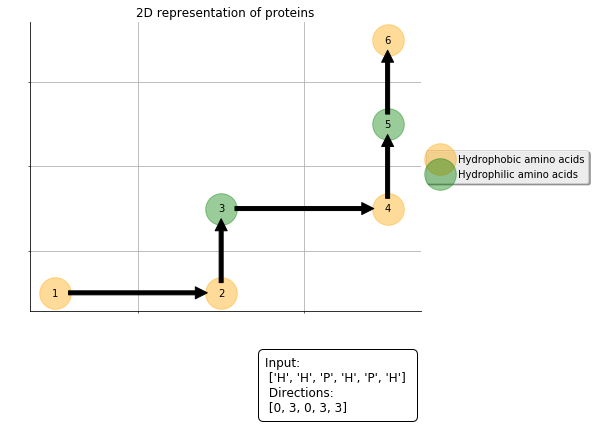

KeyboardInterrupt: 

In [13]:
import time

P = ['H', 'H', 'P', 'H', 'P', 'H']
Q= initializeQ(P, True)
gamma = .95 # discount factor for future rewards
lr= 0.7 # learning rare

current_state = 'start'
actions = []
scores = [] 

for i in range(10000):
    actions = []
    current_state = 'start'
    for j in range(len(P) - 1):
        
        if current_state == 'start':
            action = 0
        else:
            # Choose an action by as the best option from Q for current state + noise
            action= np.argmax(Q[current_state] + np.random.randn(1,MOVE_SIZE)*(1.0/(i + 2*j +1))) # become less random over time

        actions.append(action)
        next_state = str(action) if current_state == 'start' else current_state + str(action)

        r = reward(P, actions)
        future_reward = np.max(Q[next_state])
#         Q[current_state][int(action)] = (1-lr) * Q[current_state][int(action)] + lr * ( r + gamma * future_reward)
        reward_improvement = (future_reward - Q[current_state][int(action)])
        value_change = lr*(r + reward_improvement)
        Q[current_state][int(action)] = Q[current_state][int(action)] + value_change
        
        current_state = next_state
        scores.append(qScoreDictionary(Q))
    # print solution
    time.sleep(1)
    clear_output()
    plotSolution(P, actions)
    plt.show()

        

        
plotSolution(P, actions)
plt.plot(scores)
plt.title('Q learning score evolution, final reward %s ' % (reward(P, actions, True)))
plt.show()
Q